# Linear Support Vector Machine (SVM)

We've seen how to frame a problem as a differentiable program in the optimising functions example. 
Now we can take a look a more usable example; a linear Support Vector Machine (SVM). Note that the model and loss used
in this guide are based on the code found [here](https://github.com/kazuto1011/svm-pytorch).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed. 

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.3.2


## SVM Recap

Recall that an SVM tries to find the maximum margin hyperplane which separates the data classes. For a soft margin SVM
where $\textbf{x}$ is our data, we minimize:

\begin{equation}
\left[\frac 1 n \sum_{i=1}^n \max\left(0, 1 - y_i(\textbf{w}\cdot \textbf{x}_i - b)\right) \right] + \lambda\lVert \textbf{w} \rVert^2
\end{equation}

We can formulate this as an optimization over our weights $\textbf{w}$ and bias $b$, where we minimize the
hinge loss subject to a level 2 weight decay term. The hinge loss for some model outputs
$z = \textbf{w}\textbf{x} + b$ with targets $y$ is given by:

\begin{equation}
\ell(y,z) = \max\left(0, 1 - yz \right)
\end{equation}

## Defining the Model

Let's put this into code. First we can define our module which will project the data through our weights and offset by
a bias. Note that this is identical to the function of a linear layer.

In [2]:
import torch.nn as nn

class LinearSVM(nn.Module):
    """Support Vector Machine"""

    def __init__(self):
        super(LinearSVM, self).__init__()
        self.w = nn.Parameter(torch.randn(1, 2), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        h = x.matmul(self.w.t()) + self.b
        return h

Next, we define the hinge loss function:

In [3]:
import torch

def hinge_loss(y_pred, y_true):
    return torch.mean(torch.clamp(1 - y_pred.t() * y_true, min=0))

Creating Synthetic Data
-----------------------------------------------

Now for some data, 1024 samples should do the trick. We normalise here so that our random init is in the same space as
the data:

In [4]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs

X, Y = make_blobs(n_samples=1024, centers=2, cluster_std=1.2, random_state=1)
X = (X - X.mean()) / X.std()
Y[np.where(Y == 0)] = -1
X, Y = torch.FloatTensor(X), torch.FloatTensor(Y)

Visualizing the Training
----------------------------------------

We now aim to create a nice visualisation, such as the one below. 

![svmgif](https://raw.githubusercontent.com/ecs-vlc/torchbearer/master/docs/_static/img/svm_fit.gif)

The code for the visualisation (using [pyplot](https://matplotlib.org/api/pyplot_api.html)) is a bit ugly but we'll
try to explain it to some degree. First, we need a mesh grid `xy` over the range of our data:

In [5]:
delta = 0.01
x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
x, y = np.meshgrid(x, y)
xy = list(map(np.ravel, [x, y]))

Now things get a little strange. We start by evaluating our model over the mesh grid from earlier.

For our outputs $z \in \textbf{Z}$, we can make some observations about the decision boundary. First, that we are
outside the margin if $z \lt -1$ or $z \gt 1$. Conversely, we are inside the margine where $z \gt -1$
or $z \lt 1$. 

The next bit is a bit of a hack to get the update of the contour plot working. If a reference to the plot is already in state we just remove the old one and add a new one, otherwise we add it and show the plot. Finally, we call mypause to trigger an update. You could just use plt.pause, however, it grabs the mouse focus each time it is called which can be annoying. Instead, mypause is taken from stackoverflow.

This whole process is shown in the callback below:


In [6]:
from torchbearer import callbacks

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

@callbacks.on_step_training
@callbacks.only_if(lambda state: state[torchbearer.BATCH] % 10 == 0)
def draw_margin(state):
    w = state[torchbearer.MODEL].w[0].detach().to('cpu').numpy()
    b = state[torchbearer.MODEL].b[0].detach().to('cpu').numpy()

    z = (w.dot(xy) + b).reshape(x.shape)
    z[np.where(z > 1.)] = 4
    z[np.where((z > 0.) & (z <= 1.))] = 3
    z[np.where((z > -1.) & (z <= 0.))] = 2
    z[np.where(z <= -1.)] = 1

    plt.clf()
    plt.scatter(x=X[:, 0], y=X[:, 1], c="black", s=10)
    plt.contourf(x, y, z, cmap=plt.cm.jet, alpha=0.5)
    fig.canvas.draw()

Subgradient Descent
----------------------------------------------

Since we don't know that our data is linearly separable, we would like to use a soft-margin SVM. That is, an SVM for
which the data does not all have to be outside of the margin. This takes the form of a weight decay term,
$\lambda\lVert \textbf{w} \rVert^2$ in the above equation. This term is called weight decay because the gradient
corresponds to subtracting some amount ($2\lambda\textbf{w}$) from our weights at each step. With torchbearer we
can use the `L2WeightDecay` callback to do this. This whole process is known as subgradient descent because we
only use a mini-batch (of size 32 in our example) at each step to approximate the gradient over all of the data. This is
proven to converge to the minimum for convex functions such as our SVM. At this point we are ready to create and train
our model:

<IPython.core.display.Javascript object>


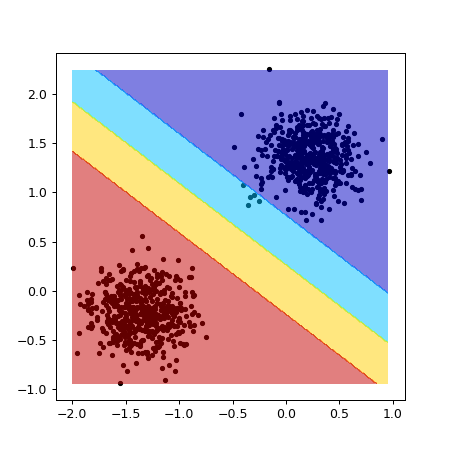

In [7]:
from torchbearer import Trial
from torchbearer.callbacks import L2WeightDecay, ExponentialLR

import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

fig = plt.figure(figsize=(5, 5))

svm = LinearSVM()
model = Trial(svm, optim.SGD(svm.parameters(), 0.1), hinge_loss, ['loss'],
              callbacks=[draw_margin, ExponentialLR(0.999, step_on_batch=True), L2WeightDecay(0.01, params=[svm.w])]).to(device)
model.with_train_data(X, Y, batch_size=32)
model.run(epochs=50, verbose=1)

fig.savefig('svm.png', bbox_inches='tight')

Final Comments
------------------------------------

So, there you have it, a fun differentiable programming example with a live visualisation in under 100 lines of code
with torchbearer. It's easy to see how this could become more useful, perhaps finding a way to use the kernel trick with
the standard form of an SVM (essentially an RBF network). You could also attempt to write some code that saves the gif
from earlier. We had some but it was beyond a hack, can you do better?